Training School # 4 of NEUBIAS COST Action
February 29th-March 3rd, 2020, Bordeaux

Author: Ignacio Arganda-Carreras

# Deep Learning example: U-Net for super-resolution

---
## Introduction
This is a notebook that shows how to design and train a U-Net-like network for super-resolution on Electron Miscroscopy (EM) images. The aim is to train the network using low resolution versions of the images as input, and the high resolution versions as output.

<figure>
<center>
<img src="https://drive.google.com/uc?id=1KUCwas63FD6AfiKOetiGjLRR6oldNkKC" width="450">
</figure>



## Data
The image data used in the notebook was produced by [Lichtman Lab at Harvard University](https://lichtmanlab.fas.harvard.edu/) (Daniel R. Berger, Richard Schalek, Narayanan "Bobby" Kasthuri, Juan-Carlos Tapia, Kenneth Hayworth, Jeff W. Lichtman). Their corresponding biological findings were published in [Cell (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26232230).
The training and test data sets are both 3D stacks of 100 sections from a serial section Scanning Electron Microscopy (ssSEM) data set of mouse cortex. The microcube measures 6 x 6 x 3 microns approx., with a resolution of 6 x 6 x 30 nm/voxel. For simplicity, in this notebook we will only use 10 sections of the test set.

## Getting started
First, we make sure we are using Tensorflow version compatible with DeepImageJ (<= 1.13).


In [0]:
# Use Tensorflow and Keras versions compatible with DeepImageJ
%pip install tensorflow-gpu==1.15.0
%pip install keras==2.2.4

     |████████████████████████████████| 411.5MB 40kB/s 
     |████████████████████████████████| 317kB 8.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


Then, we load our Google Drive as a local folder so we can access the image files.

(Notice we expect you to have already this notebook under your `Colab Notebooks` in a folder called `U-Net-Super-resolution`. Inside that folder you should add the `train` and `test` image folders.)

In [0]:
# load drive as local folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now we should be able to read the list of **100 training images**.

In [0]:
import os

# Path to the training images
train_path = '/content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/Neubias-TS15-images/train/'

# Read the list of file names
train_filenames = [x for x in os.listdir( train_path ) if x.endswith(".tif")]

print( 'Images loaded: ' + str( len(train_filenames)) )

Images loaded: 100


Next, we read the 100 images into memory. This **may take some time (~1 minute)** the first time we execute the cell.


Text(0.5, 1.0, 'Full-size training image')

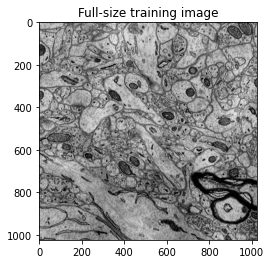

In [0]:
from skimage.util import img_as_ubyte
from skimage import io
from matplotlib import pyplot as plt

# read training images
train_img = [ img_as_ubyte( io.imread( train_path + x ) ) for x in train_filenames ]

# display first image
plt.imshow( train_img[0], 'gray' )
plt.title( 'Full-size training image' )

## Preparing the training data
Now, we are going to create the training set by cropping the input images into **patches of 256 x 256 pixels**.


Text(0.5, 1.0, 'Training patch at full resolution')

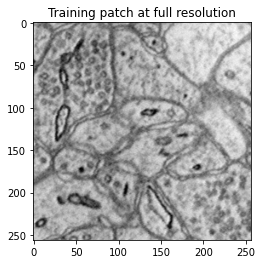

In [0]:
# create patches of 256x256 pixels => split each image in 4x4 tiles
import numpy as np
def create_patches( imgs, num_x_patches, num_y_patches ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        num_x_patches: number of patches in the X axis
        num_y_patches: number of patches in the Y axis
        
    Returns:
        list of image patches
    '''
    original_size = imgs[0].shape
    patch_width = original_size[ 0 ] // num_x_patches
    patch_height = original_size[ 1 ] // num_y_patches
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( 0, num_x_patches ):
            for j in range( 0, num_y_patches ):
                patches.append( image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ] )
    return patches
# use method to create patches
# train_patches = create_patches( train_img, 4, 4 )

def create_ranodm_patches( imgs, n, shape ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        n: number of patches
        shape: 2D array with the size of the patches. Example: [256, 256]
        
    Returns:
        list of image patches
    '''
    original_size = imgs[0].shape
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( n ):
          r = np.random.randint(0,original_size[0]-shape[0])
          c = np.random.randint(0,original_size[1]-shape[1])
          patches.append( image[ r : r + shape[0],
                                  c : c + shape[0] ] )
    return patches
# use method to create patches
train_patches = create_ranodm_patches( train_img, 30,[256,256] )

# display one patch
plt.imshow( train_patches[0], 'gray' )
plt.title( 'Training patch at full resolution' )

# We will use these patches as "ground truth" for training

Since we do not have the equivalent images at low resolution, we **simulate them by using Gaussian blur** (see the work of [Fang *et al*. (2019)](https://www.biorxiv.org/content/10.1101/740548v3) for more details about this strategy).

Text(0.5, 1.0, 'Ground truth')

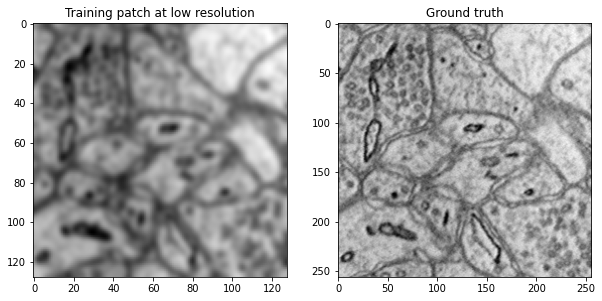

In [0]:
from skimage import filters
from skimage.transform import resize
# Create corresponding training patches synthetically by adding noise
# and downsampling the images (see https://www.biorxiv.org/content/10.1101/740548v3)

def classic_crappify(img):
    img = filters.gaussian(img, sigma=3) + 1e-6
    img = resize(img, (img.shape[0] // 2, img.shape[1] // 2),
                       anti_aliasing=True)
    return img

# Add noise
crappified_patches = [classic_crappify(x) for x in train_patches]

# Display corresponding first patch at low resolution
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( crappified_patches[0], 'gray' )
plt.title( 'Training patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_patches[0], 'gray' )
plt.title( 'Ground truth' )

# NOTE: images have now values between 0.0 and 1.0

## Network definition
Next, we define our U-Net-like network, with 3 resolution levels in the contracting path, a bottleneck, and 3 resolution levels in the expanding path.

As loss function, we use the mean squared error (MSE) between the expected and the predicted pixel values, and we also include the mean absolute error (MAE) as a control metric.


In [0]:
# Input image size
patch_shape = crappified_patches[0].shape
train_width = patch_shape[0]
train_height = patch_shape[1]


# Create U-Net for super-resolution

from keras.models import Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D
from keras.layers import concatenate
from keras.optimizers import Adam

inputs = Input((train_width, train_height, 1))

# Upsample input image to get an image of super-resolution
s = UpSampling2D( size=(2,2) )( inputs )

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = AveragePooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = AveragePooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = AveragePooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1], axis=3)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c7)

model = Model(inputs=[inputs], outputs=[outputs])
# compile the model with RMSProp as optimizer, MSE as loss function and MAE as metric
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         up_sampling2d_1[0][0]            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]      

## Training the network
To follow Tensorflow standards, the input and output of the network have to be reshaped 256 x 256 x 1. Notice both input and ground truth images have their intensities scaled between 0.0 and 1.0.

Important training information:
*   `Validation split`: percentage of training samples used for validation. Set to a random 10%.
*   `Epochs`: which defines the maximum number of epochs the model will be trained. Initially set to 20.
*   `Patience`: number of epochs that produced the monitored quantity (validation MSE) with no improvement after which training will be stopped. Initially set to 5.
*   `Batch size`:  the number of training examples in one forward/backward pass. Initially set to 6.



In [0]:
# Train the network
from keras.callbacks import EarlyStopping
import numpy as np

numEpochs = 50
# earlystopper = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

# training input
input_shape = ( train_width, train_height, 1 ) # 128x128x1
X_train = [np.reshape(x, input_shape ) for x in crappified_patches]
X_train = np.asarray(X_train)

# training ground truth
output_shape = ( train_width*2, train_height*2, 1 ) # 256x256x1
Y_train = [x/255 for x in train_patches] # normalize between 0 and 1
Y_train = [np.reshape( x, output_shape ) for x in Y_train]
Y_train = np.asarray(Y_train)

history = model.fit( X_train, Y_train, validation_split=0.1, batch_size = 6,
                    epochs=numEpochs) # , callbacks=[earlystopper])

Train on 4455 samples, validate on 495 samples
Epoch 1/50
4455/4455 [==============================] - 28s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0341 - val_loss: 0.0017 - val_mean_absolute_error: 0.0327
Epoch 2/50
4455/4455 [==============================] - 27s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 3/50
4455/4455 [==============================] - 27s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0337 - val_loss: 0.0018 - val_mean_absolute_error: 0.0327
Epoch 4/50
4455/4455 [==============================] - 28s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0336 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 5/50
4455/4455 [==============================] - 28s 6ms/step - loss: 0.0019 - mean_absolute_error: 0.0334 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311
Epoch 6/50
4455/4455 [==============================] - 28s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0333 - va

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-6139c69e186c>", line 19, in <module>
    epochs=numEpochs) # , callbacks=[earlystopper])
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1472, in __call__
    run_metadata_ptr)
KeyboardIn

KeyboardInterrupt: ignored


We can now plot the loss and MAE curves for the training and validation sets.


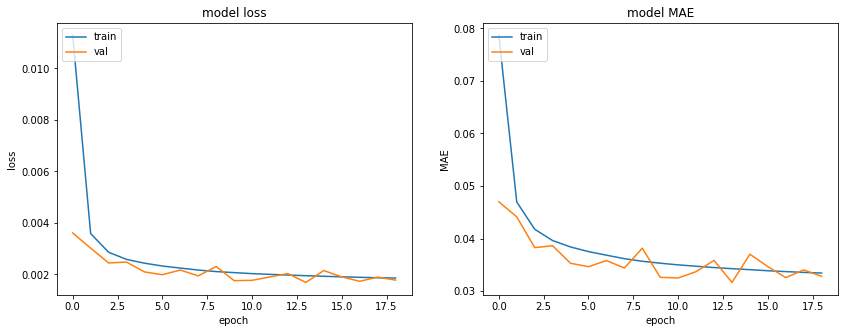

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# summarize history for loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Check performance in the test set
Finally we can load some test images for testing.

In [0]:
# Now we load some unseen images for testing
test_path = '/content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/Neubias-TS15-images/test/'

test_filenames = [x for x in os.listdir( test_path ) if x.endswith(".tif")]

print( 'Available test images: ' + str( len(test_filenames)) )

Available test images: 10


Text(0.5, 1.0, 'Ground truth')

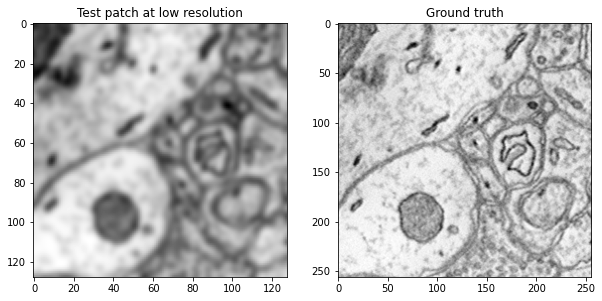

In [0]:
# Read test images
test_img = [ img_as_ubyte( io.imread( test_path + x ) ) for x in test_filenames ]
# create patches of 256x256 pixels => split each image in 4x4 tiles
import numpy as np
def create_patches( imgs, num_x_patches, num_y_patches ):
    ''' Create a list of images patches out of a list of images
    Args:
        imgs: list of input images
        num_x_patches: number of patches in the X axis
        num_y_patches: number of patches in the Y axis
        
    Returns:
        list of image patches
    '''
    original_size = imgs[0].shape
    patch_width = original_size[ 0 ] // num_x_patches
    patch_height = original_size[ 1 ] // num_y_patches
    
    patches = []
    for n in range( 0, len( imgs ) ):
        image = imgs[ n ]
        for i in range( 0, num_x_patches ):
            for j in range( 0, num_y_patches ):
                patches.append( image[ i * patch_width : (i+1) * patch_width,
                                      j * patch_height : (j+1) * patch_height ] )
    return patches
# Create patches the same way as before
test_patches = create_patches( test_img, 4, 4 )

# Add noise
crappified_test_patches = [classic_crappify(x) for x in test_patches]

# Display corresponding first patch at low resolution
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( crappified_test_patches[0], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( test_patches[0], 'gray' )
plt.title( 'Ground truth' )



We can evaluate the network performance in test using both the MSE and MAE metrics.


In [0]:
# Evaluate trained network on test images
X_test = [np.reshape(x, input_shape ) for x in crappified_test_patches]
X_test = np.asarray(X_test)

Y_test = [x/255 for x in test_patches] # normalize between 0 and 1
Y_test = [np.reshape( x, output_shape ) for x in Y_test]
Y_test = np.asarray(Y_test)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test , batch_size=16)
print('test loss, test MAE:', results)




# Evaluate on test data
160/160 [==============================] - 0s 2ms/step
test loss, test MAE: [0.0017457937006838619, 0.031864514388144013]


And also display some patches for qualitative evaluation.


# Generate predictions for 3 samples
predictions shape: (3, 256, 256, 1)


Text(0.5, 1.0, 'Prediction')

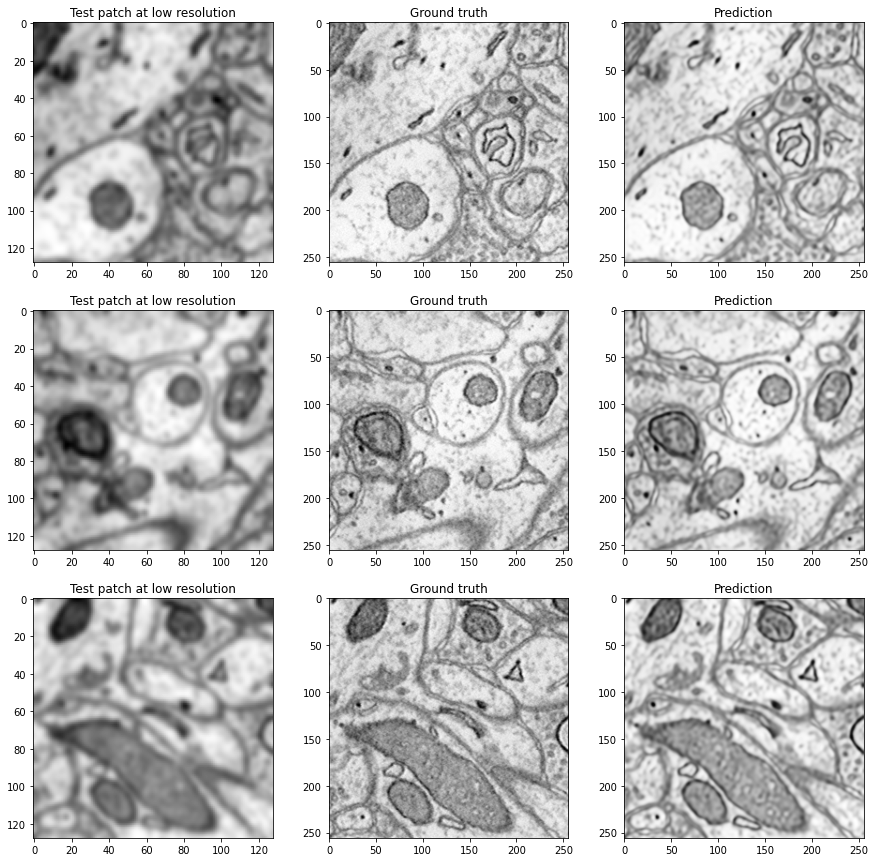

In [0]:
print('\n# Generate predictions for 3 samples')
predictions = model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

# Display corresponding first 3 patches
plt.figure(figsize=(15,15))
plt.subplot(3, 3, 1)
plt.imshow( crappified_test_patches[0], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 2)
plt.imshow( test_patches[0], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 3)
plt.imshow( predictions[0,:,:,0], 'gray' )
plt.title( 'Prediction' )

plt.subplot(3, 3, 4)
plt.imshow( crappified_test_patches[1], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 5)
plt.imshow( test_patches[1], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 6)
plt.imshow( predictions[1,:,:,0], 'gray' )
plt.title( 'Prediction' )

plt.subplot(3, 3, 7)
plt.imshow( crappified_test_patches[2], 'gray' )
plt.title( 'Test patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(3, 3, 8)
plt.imshow( test_patches[2], 'gray' )
plt.title( 'Ground truth' )
# ant its prediction
plt.subplot(3, 3, 9)
plt.imshow( predictions[2,:,:,0], 'gray' )
plt.title( 'Prediction' )

## Save model to import it later in DeepImageJ
Now, we will see how to saved the train model into a file so we can later reuse it in the DeepImageJ plugin.

In [0]:
# !rm -rf save_model

# Save entire model to the Tensorflow format SavedModel

import tensorflow as tf
import keras
from keras import backend as K

OUTPUT_DIR = "/content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/new_model"

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  model.input},
            outputs = {'output': model.output})

signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/new_model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/new_model/saved_model.pb


b'/content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/new_model/saved_model.pb'

In [0]:
# Check if the folder has been properly created
import os
os.chdir('/content/drive/My Drive/EDUCACION/Papers&Congress/Conferences/NEUBIAS/')
!ls -l

total 10170
drwx------ 4 root root    4096 Mar 23 07:48 Neubias-TS15-images
drwx------ 3 root root    4096 Mar 26 10:55 new_model
drwx------ 2 root root    4096 Mar 20 17:55 saved_model
-rw------- 1 root root 8928235 Mar 20 18:01 saved_model.zip
-rw------- 1 root root 1473310 Mar 26 10:54 U_Net_4_superresolution_in_EM.ipynb


In [0]:
# Zip folder with the save model
from google.colab import files

!zip new_model -r new_model/

  adding: new_model/ (stored 0%)
  adding: new_model/variables/ (stored 0%)
  adding: new_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: new_model/variables/variables.index (deflated 51%)
  adding: new_model/saved_model.pb (deflated 90%)


In [0]:
# Check if the file is there
!ls -l

total 13649
drwx------ 4 root root    4096 Mar 23 07:48 Neubias-TS15-images
drwx------ 3 root root    4096 Mar 26 10:55 new_model
-rw------- 1 root root 3562386 Mar 26 10:55 new_model.zip
drwx------ 2 root root    4096 Mar 20 17:55 saved_model
-rw------- 1 root root 8928235 Mar 20 18:01 saved_model.zip
-rw------- 1 root root 1473308 Mar 26 10:55 U_Net_4_superresolution_in_EM.ipynb


In [0]:
# And download!
files.download("new_model.zip")